In [2]:
from sbcbinaryformat import Streamer, Writer
import numpy as np
import matplotlib.pyplot as plt

from GetEvent import GetEvent

from ana import AcousticT0 
from scipy.signal import firwin, filtfilt
from scipy.optimize import least_squares
import importlib

In [3]:
importlib.reload(AcousticT0)

<module 'ana.AcousticT0' from '/exp/e961/app/users/runze/projects/LAr10Ana/ana/AcousticT0.py'>

In [4]:
TEST_RUN = "/exp/e961/data/SBC-25-daqdata/20250611_1/"
# TEST_RUN2 = "/exp/e961/app/users/runze/data/20251120_12/"
# TEST_RUN2 = "/exp/e961/app/users/runze/data/20251211_6/"
TEST_RUN2 = "/exp/e961/app/users/runze/data/20251121_5/"
# TEST_RUN2 = "/exp/e961/data/users/gputnam/SBC-25-daqdata-test/20251103_1/"
TEST_EVT = 4

In [5]:
data = GetEvent(TEST_RUN2, TEST_EVT,strictMode=False)
data.keys()

/exp/e961/app/users/runze/projects/LAr10Ana/GetEvent.py:106: UserWarning: No scintillation file present in the run directory. Data will not be available in the returned dictionary.
  warnings.warn("No scintillation file present in the run directory. Data will not be available in the returned dictionary.")


dict_keys(['acoustics', 'scintillation', 'cam', 'event_info', 'plc', 'slow_daq', 'run_info', 'run_control'])

In [6]:
data["cam"].keys()

dict_keys(['loaded', 'c1', 'c2', 'c3'])

In [7]:
data["acoustics"].keys()

dict_keys(['loaded', 'Range', 'DCOffset', 'Waveforms', 'sample_rate'])

In [8]:
data["acoustics"]["Range"]


array([[ 2000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]],
      dtype=int16)

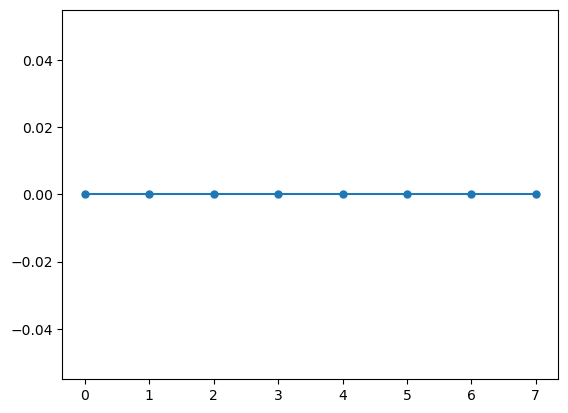

In [9]:
# DC Offset by channel
_ = plt.plot(data["acoustics"]["DCOffset"][0], marker=".", markersize=10)

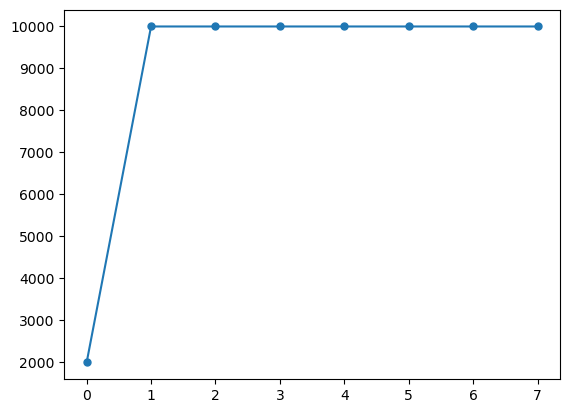

In [10]:
# DC Offset by channel
_ = plt.plot(data["acoustics"]["Range"][0], marker=".", markersize=10)

In [11]:
wvfs = data["acoustics"]["Waveforms"]
wvfs.shape

(1, 8, 950001)

In [12]:
np.float64([[1e2, 1e3, 1e4, 1e5]]).shape

(1, 4)

In [13]:
# plot the first triggered waveform in each channel
# if channel 7 raw reading is ADC -35/1e4
# if channel 7 raw reading is bits, -35/2**15
# MB.PT1101 := AIn.PT1101 * (-35.0* el3052bits);
wvfs_psi = wvfs*(-35/2**16)
# wvfs_psi = wvfs*(-35/1e4)

# for channel in range(wvfs.shape[1]):
#     plt.plot(wvfs_psi[0, channel, :],label="channel"+str(channel))
#     #plt.plot(wvfs[0, channel, :],label="channel"+str(channel))
# plt.legend()
# plt.xlabel("time/microseconds")
# plt.ylabel("pressure/psi")


# channel 0 hydraulic trigger 15bits
# channel 1-6 acoustic
# channel 7, PT 
# that is when compress happens, and with a delay, the pressure drops

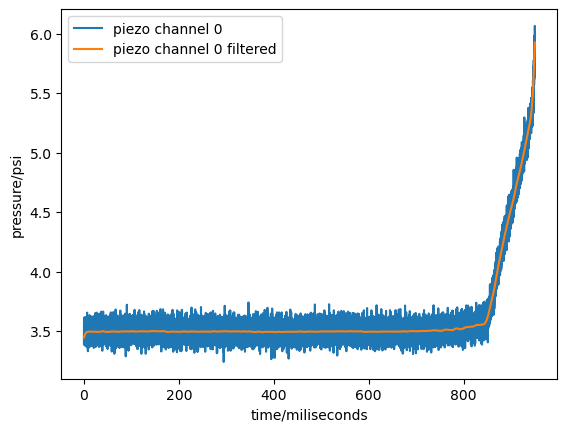

In [23]:
piezo0 = wvfs_psi[0, 7, :]
xlimit = [0, 800]
ylimit = [-22.5,-20]
ylimit = [-20,-18]
# time in miliseconds
total_time = len(piezo0)
time_list_ms = [i/1e3 for i in range(0,total_time,1)]

# add low pass filter
# assuming 1 microsecond time resolution 1e6Hz
numtaps = 10000  # filter length (longer = sharper cutoff)
Fs= 1000000 # sampling rate
Fc = 10 # low pass filter in Hz
fir = firwin(numtaps, Fc, pass_zero=True,window='hamming', fs=Fs)

piezo0_filtered = filtfilt(fir, [1.0], piezo0)
piezoslope0 = (+piezo0_filtered[1:]-piezo0_filtered[:-1])*1e3 # in bar/ms
plt.plot(time_list_ms,piezo0, label="piezo channel 0")
plt.plot(time_list_ms,piezo0_filtered, label="piezo channel 0 filtered")
plt.xlabel("time/miliseconds")
plt.ylabel("pressure/psi")
# plt.xlim(xlimit)
# plt.ylim(ylimit)
plt.legend()

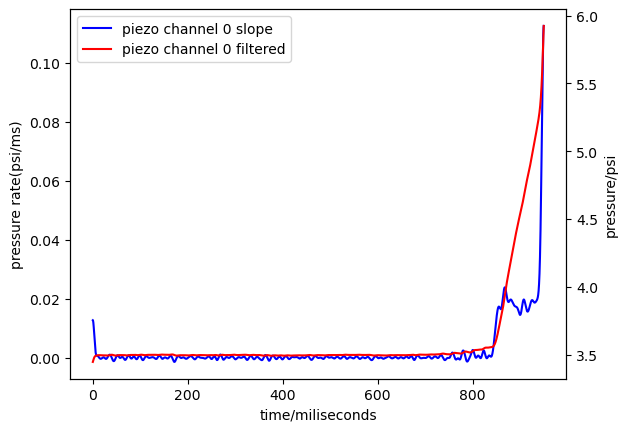

In [15]:
fig, ax1 = plt.subplots()

# First axis
l1 = ax1.plot(time_list_ms[:-1],piezoslope0, label="piezo channel 0 slope",color="blue")

ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("pressure rate(psi/ms)")
# ax1.tick_params(axis='y', labelcolor="blue")

# Second axis (shares X)
ax2 = ax1.twinx()
l2 = ax2.plot(time_list_ms,piezo0_filtered, label="piezo channel 0 filtered",color="red")
ax2.set_ylabel("pressure/psi")
# ax2.set_ylim(ylimit)

lines = l1 + l2
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels)
# plt.legend()

In [16]:
#quadratic fittings
# finding ending point, hard cut, find first time when the rate < -2e-5 psi/ms
# starting point, from [10:]
# then fitting find t0

starting_indx = 10000
# starting 10ms after data collection
print(piezoslope0[starting_indx])
ending_indx = 0
fitting_ending_indx = 0
hardcut_threshold = 0.01
for i in range(starting_indx,len(piezoslope0),1):
    if piezoslope0[i] > hardcut_threshold:
        ending_indx = i
        fitting_ending_indx = i-10000
        break
print("index",ending_indx,time_list_ms[ending_indx])
pressure_before_fit = piezo0_filtered[starting_indx:ending_indx]
time_fit_range = time_list_ms[starting_indx:ending_indx]

0.0005969246807957518
index 848190 848.19


In [17]:
data["slow_daq"].keys()

dict_keys(['loaded', 'time_ms', 'valves', 'TT6415', 'PT1101', 'TT2118', 'TT2119', 'PT2121', 'PT3332', 'PT3333', 'CYL3334_FCALC', 'LT3335', 'SERVO3321_OUT', 'SERVO3321_IN'])

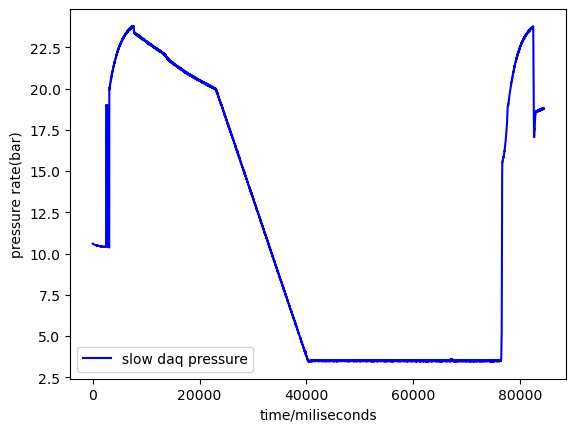

In [18]:
slowdaq_PT = data["slow_daq"]['PT1101']
slowdaq_time = [i*10 for i in range(len(slowdaq_PT))]
fig, ax1 = plt.subplots()
startpoint = 10000
endpoint = 10750
# l1 = ax1.plot(slowdaq_time[startpoint:endpoint],slowdaq_PT[startpoint:endpoint], label="slow daq pressure",color="blue")
l1 = ax1.plot(slowdaq_time,slowdaq_PT, label="slow daq pressure",color="blue")

ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("pressure rate(bar)")
# ax1.set_xlim(10000, 820)
# ax1.set_ylim(7.5,12)
ax1.legend()

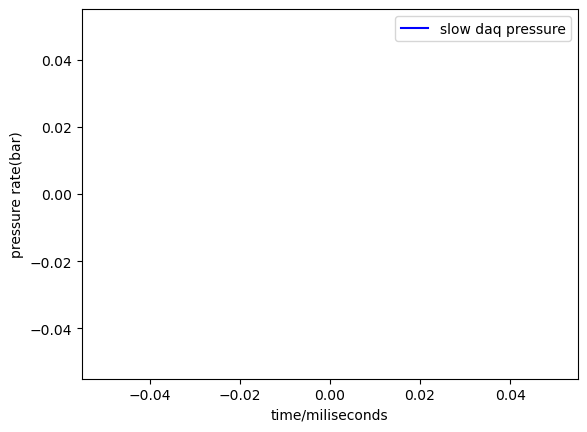

In [19]:
slowdaq_PT = data["slow_daq"]['PT2121']

slowdaq_time = [i*10 for i in range(len(slowdaq_PT))]
fig, ax1 = plt.subplots()
# startpoint = 10000
# endpoint = 10730
startpoint = 10815
endpoint = 10910
l1 = ax1.plot(slowdaq_time[startpoint:endpoint],slowdaq_PT[startpoint:endpoint], label="slow daq pressure",color="blue")

ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("pressure rate(bar)")
# ax1.set_xlim(10000, 820)
# ax1.set_ylim(7.5,12)
ax1.legend()

slowdaq_time_wo_sync = slowdaq_time[startpoint:endpoint]
slowdaq_PT_sync = slowdaq_PT[startpoint:endpoint]
slowdaq_time_sync = []
for i in range(len(slowdaq_time_wo_sync)):
    slowdaq_time_sync.append(slowdaq_time_wo_sync[i]-startpoint*10)

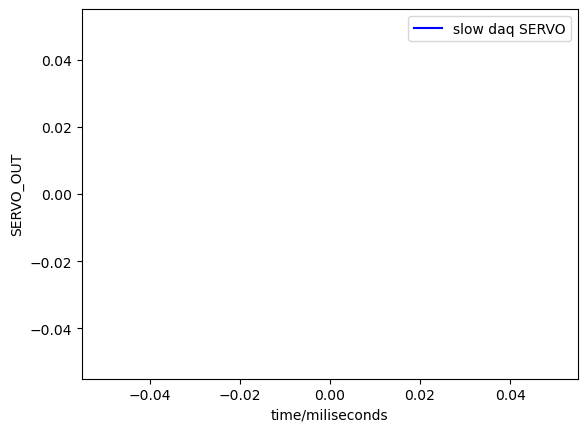

In [20]:
slowdaq_SERVO = data["slow_daq"]['SERVO3321_OUT']

fig, ax1 = plt.subplots()
# startpoint = 10000
# endpoint = 10730
startpoint = 10815
endpoint = 10910
l1 = ax1.plot(slowdaq_time[startpoint:endpoint],slowdaq_SERVO[startpoint:endpoint], label="slow daq SERVO",color="blue")

ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("SERVO_OUT")
# ax1.set_xlim(10000, 820)
# ax1.set_ylim(7.5,12)
ax1.legend()


slowdaq_SERVO_sync = slowdaq_SERVO[startpoint:endpoint]

In [21]:
#find the starting time should be around 2.25 bar
print(slowdaq_PT[10000], "bar")
slowdaq_startpoint = 0
window_length = 10
pressure_threshold_slowdaq = 4.5
for i in range(window_length+1,len(slowdaq_PT),1):
    if slowdaq_PT[i-window_length]<pressure_threshold_slowdaq and slowdaq_PT[i]>pressure_threshold_slowdaq: # before the window length, the value is below 5 bar and afterwards, the pressure if higher
    # if slowdaq_PT[i-window_length]<5:
        slowdaq_startpoint=i*10 # recorde the time in miliseond
        break
print(slowdaq_startpoint,"ms")
print(slowdaq_PT[int(slowdaq_startpoint/10)],"bar")




IndexError: index 10000 is out of bounds for axis 0 with size 8443

In [ ]:
fig, ax1 = plt.subplots()

# First axis
l1 = ax1.plot(slowdaq_time_sync,slowdaq_PT_sync, label="slowdaq 0",color="orange")

ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("pressure(bar)")
# ax1.tick_params(axis='y', labelcolor="blue")

# Second axis (shares X)

l2 = ax1.plot(time_fit_range,pressure_before_fit, label="piezo channel 0 filtered",color="red")


ax2 = ax1.twinx()
l3 = ax2.plot(time_list_ms[:-1],piezoslope0, label="piezo channel 0 slope",color="blue")
ax2.set_ylabel("pressure rate/(psi/ms)")

# ax2.set_ylim(ylimit)

lines = l1 + l2+l3
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels)
# plt.legend()

In [ ]:
slowdaq_PT_sync_offset = [] # fixed the offset between acoustic and slowdaq
for i in range(len(slowdaq_PT_sync)):
     slowdaq_PT_sync_offset.append(slowdaq_PT_sync[i]+0.5)
fig, ax1 = plt.subplots()

# First axis
l1 = ax1.plot(slowdaq_time_sync,slowdaq_PT_sync_offset, label="slowdaq 0",color="orange")

ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("pressure(bar)")

# ax1.tick_params(axis='y', labelcolor="blue")

# Second axis (shares X)

l2 = ax1.plot(time_fit_range,pressure_before_fit, label="piezo channel 0 filtered",color="red")
# ax1.set_xlim(0,max(time_fit_range))
ax1.set_ylim(3.8,max(pressure_before_fit))

ax2 = ax1.twinx()
l3 = ax2.plot(time_list_ms[:-1],piezoslope0, label="piezo channel 0 slope",color="blue")
ax2.set_ylabel("pressure rate/(psi/ms)")

# ax2.set_ylim(ylimit)

lines = l1 + l2+l3
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels)
# plt.legend()

In [ ]:
slowdaq_SERVO_sync_offset = [] # fixed the offset between acoustic and slowdaq
for i in range(len(slowdaq_SERVO_sync)):
     slowdaq_SERVO_sync_offset.append(slowdaq_SERVO_sync[i]+0)
fig, ax1 = plt.subplots()
# First axis
l1 = ax1.plot(slowdaq_time_sync,slowdaq_PT_sync_offset, label="slowdaq 0",color="orange")

ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("pressure(bar)")

# ax1.tick_params(axis='y', labelcolor="blue")

# Second axis (shares X)

l2 = ax1.plot(time_fit_range,pressure_before_fit, label="piezo channel 0 filtered",color="red")
# ax1.set_xlim(0,max(time_fit_range))
ax1.set_ylim(3.8,max(pressure_before_fit))

ax2 = ax1.twinx()
l3 = ax2.plot(slowdaq_time_sync,slowdaq_SERVO_sync_offset, label="slow daq SERVO",color="blue")
ax2.set_ylabel("SERVO_OUT")
ax2.set_ylim(-10,20)

# ax2.set_ylim(ylimit)

lines = l1 + l2+l3
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels)


In [ ]:


# add low pass filter
# assuming 1 microsecond time resolution 1e6Hz
numtaps = 15000  # filter length (longer = sharper cutoff)
Fs= 1000000 # sampling rate
Fc = 10 # low pass filter in Hz
fir = firwin(numtaps, Fc, window='hamming', fs=Fs)

slope0_filtered = filtfilt(fir, [1.0], piezoslope0)
plt.plot(time_list_ms[:-1],piezoslope0, label="piezo slope channel 0")
plt.plot(time_list_ms[:-1],slope0_filtered, label="piezo channel 0 filtered")
plt.xlabel("time/miliseconds")
plt.ylabel("pressure/psi")
# plt.xlim(xlimit)
# plt.ylim(ylimit)
plt.legend()


# fig, ax1 = plt.subplots()

# # First axis
# l1 = ax1.plot(time_list_ms[:-1],piezoslope0, label="piezo channel 0 slope",color="blue")
# ax1.set_xlabel("time/miliseconds")
# ax1.set_ylabel("pressure rate(psi/ms)")
# # ax1.tick_params(axis='y', labelcolor="blue")



# ax1.legend()

In [ ]:
# manually choose starting point and end point
for index in range(len(time_list_ms)):
    if time_list_ms[index]>800:
        print(index)
        break
#8e5

In [ ]:
def piecewise_with_t(params, x):
    a, t = params
    y = np.where(x < t, 0, a*(x - t))
    return y

def residuals_with_t(params, x, y):
    return piecewise_with_t(params, x) - y

In [ ]:
# fit with function
# f =c when x<t0,
# f=a(x-t0)**2+c when x>t0
slope_before_fit = slope0_filtered[starting_indx:fitting_ending_indx]
time_fitting_range = time_list_ms[starting_indx:fitting_ending_indx]
# initial guesses:
a0 = 8e-6
t0 = 100             # t0 initial guess around 100ms
# c0 = np.mean(pressure_before_fit[:100]) # first 100 data average
p0 = [a0, t0]

# optionally set bounds: a>=0 , t within x-range, c in pressure range
bounds = ([0, min(time_fitting_range)], [np.inf, max(time_fitting_range)])

res = least_squares(residuals_with_t, p0, args=(time_fitting_range,  slope_before_fit), bounds=bounds)
a_fit, t_fit = res.x
print("fitted a, t:", a_fit, t_fit)

# plot
plt.scatter(time_fitting_range,  slope_before_fit, s=8, alpha=0.5, label='data')
xs = np.linspace(min(time_fitting_range), max(time_fitting_range), 500)
plt.plot(xs, piecewise_with_t((a_fit, t_fit), xs), 'r-', lw=2, label='fit')
plt.axvline(t_fit, color='gray', linestyle='--', label=f't={t_fit:.3f}')
plt.legend()